Любой анализ событий во времени подразумевает работу с датой или временем.

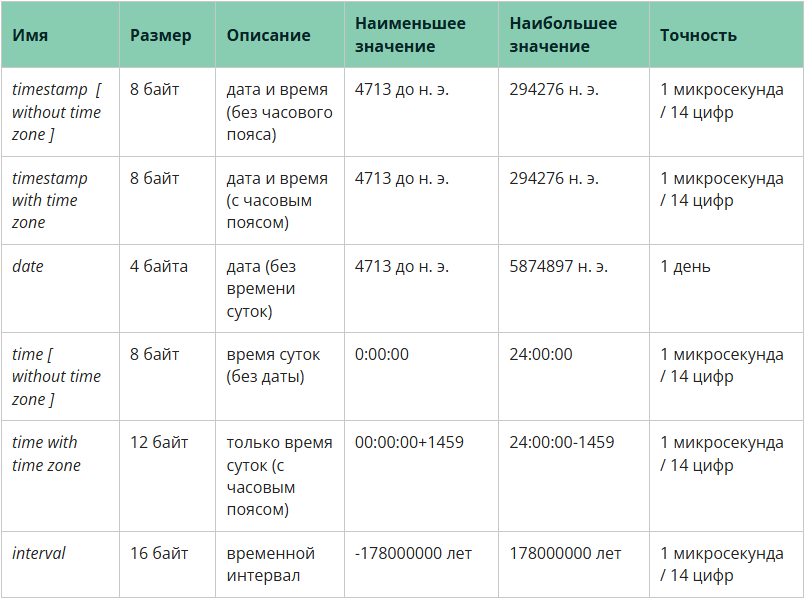

Timestamp — наиболее распространённый тип данных, так как он содержит и дату, и время, а также используется в любых логах событий, временных рядах и в большинстве системных таблиц.

In [ ]:
SELECT NOW()

SELECT CURRENT_TIMESTAMP.

Сначала попробуем узнать, в каком часовом поясе выводятся временные данные в настоящий момент. Для этого выполните команду

In [ ]:
show timezone

Давайте узнаем, сколько сейчас времени в другом регионе, например Лос-Анджелесе. Напишите запрос, который выведет текущие время и дату в часовом поясе Лос-Анджелеса ("America/Los_Angeles"). Столбец в выдаче — now (время и дата в нужном часовом поясе).

In [ ]:
select now() at time zone 'America/Los_Angeles' as now

С типом date вы уже знакомы, его реализация предельно проста. Отметим только, что тип timestamp (with/without time zone) можно легко перевести в соответствующую дату, используя синтаксис

In [ ]:
"timestamp_column"::date

Для получения текущей даты можно использовать

In [ ]:
select CURRENT_DATE
select now()::date

Предположим, у нас есть дата и время какого-то события и мы хотим посмотреть, к какой дате оно относится для Москвы и для UTC. Используйте следующий подзапрос и выведите дату в ts в Московском часовом поясе и в поясе UTC:

In [ ]:
with x as 
(
select '2018-12-31 21:00:00+00'::timestamp with time zone ts
)

In [ ]:
WITH x AS 
(
SELECT '2018-12-31 21:00:00+00'::timestamp WITH time zone ts
)
SELECT 
        (ts at time zone 'Europe/Moscow')::date dt_msk,
        (ts)::date dt_utc
FROM x

Функция extract() получает из значений даты/времени такие поля, как год или час.

Указанное поле представляет собой идентификатор, по которому из источника выбирается заданное поле. Функция extract() возвращает значения типа double precision.

In [ ]:
--Для значений timestamp это день месяца (1-31), для значений interval — число дней.

SELECT EXTRACT(DAY FROM TIMESTAMP '2001-02-16 20:38:40');
--Результат: 16

SELECT EXTRACT(DAY FROM INTERVAL '40 days 1 minute');
--Результат: 40

Давайте посчитаем помесячную статистику по доставкам, используя функцию extract. Напишите запрос, который выведет год, месяц и количество доставок. Отсортируйте по году и по месяцу в порядке возрастания. Столбцы в выдаче: year_n (номер года), month_n (номер месяца), qty (количество доставок).

In [ ]:
SELECT 
    EXTRACT(YEAR FROM ship_date) AS year_n,
    EXTRACT(MONTH FROM ship_date) AS month_n,
    COUNT(*) AS qty
FROM sql.shipment
GROUP BY year_n, month_n
ORDER BY year_n ASC, month_n ASC

Например, вы хотите вывести год, месяц и день со специфическим разделителем или получить текстовое наименование месяца или дня недели. По результату работы она очень близка к extract(), но больше нацелена именно на форматирование. Ниже вы видите таблицу с примерами вызовов:

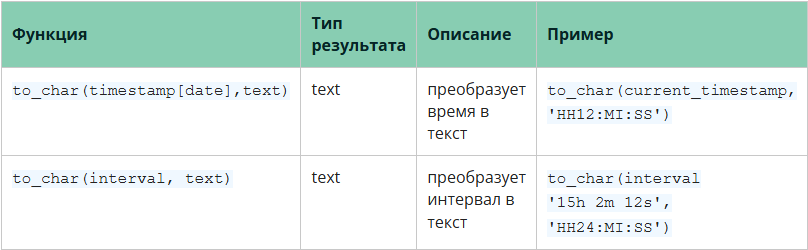

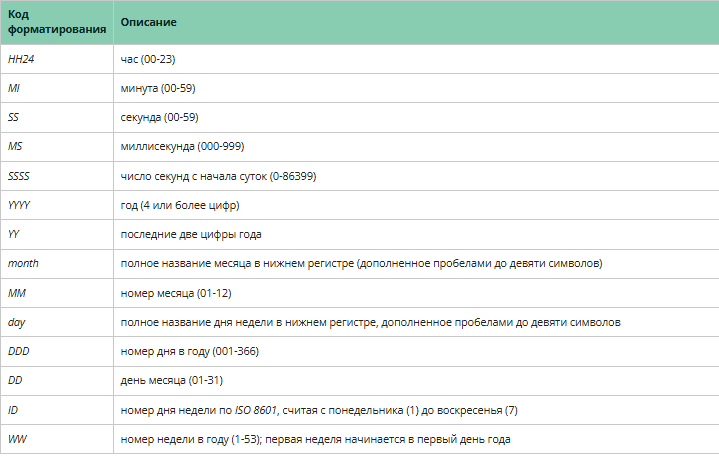

Предположим, мы хотим вывести сегодняшнюю дату в формате "Hello! Today is #название дня недели год.название месяца.день#" текстом. Для этого нужно выполнить следующий код: 

In [ ]:
select to_char(now(),'"Hello! Today is" DAY yyyy-Mon-dd')

Давайте выведем текст текущего времени для сервиса точного времени. Напишите запрос, который выводит текст "Точное время x часов y минут z секунд" (текст в кавычки заключать не нужно), где x, y, z — часы, минуты и секунды соответственно, при условии, что сообщение нужно вывести для московского часового пояса. Время введите в 24-часовом формате. Столбцы в выдаче: msg (сообщение).

In [ ]:
SELECT 
    'Точное время ' || 
    to_char(CURRENT_TIMESTAMP AT TIME ZONE 'Europe/Moscow', 'HH24 часов MI минут SS секунд') AS msg

Функция date_trunc() позволяет отсечь заданное время, дату или дату со временем до нужной точности.

In [ ]:
select date_trunc('minute',now())

Давайте подготовим данные для квартальной отчётности компании. Напишите запрос, который выведет дату доставки, округлённую до квартала, и общую массу доставок. Отсортируйте по кварталу в порядке возрастания. Столбцы в выдаче: q (начало квартала, тип date), total_weight (сумма масс доставок за квартал).

In [ ]:
SELECT
    date_trunc('quarter',s.ship_date)::date q,
    sum(s.weight) total_weight
FROM
    shipping.shipment s
GROUP BY 1
ORDER BY 1

К любой дате можно прибавить (и вычесть из неё) целое число X и получить другую дату, которая больше (меньше) изначальной.

In [ ]:
select '2019-01-01'::date + 10

Давайте оценим, в каком интервале совершались доставки в разных городах. Напишите запрос, который выведет разницу между последним и первым днём доставки по каждому городу. Отсортируйте по первому и второму столбцам. Столбцы в выдаче: city_name (название города) и days_active (время от первой до последней доставки в днях).

In [ ]:
SELECT
    city_name,
    (MAX(s.ship_date) - MIN(s.ship_date)) AS days_active
FROM
    sql.shipment s
    join sql.city c on c.city_id = s.city_id
GROUP BY
    city_name
ORDER BY
    city_name,
    days_active

Составим текстовый шаблон сообщения о доставке по конкретному водителю для наших клиентов. Напишите SQL-запрос, который выведет следующее сообщение для каждого водителя по форме:

Ваш заказ доставит водитель #Имя Фамилия#. Его контактный номер: #Номер#
Где #Имя Фамилия# и #Номер# взяты из справочника водителей. Если номер не указан, то выведите прочерк (-). Для номеров рекомендуем использовать COALESCE. Пример из таблицы для наглядности:

Ваш заказ доставит водитель Adel Al-Alawi. Его контактный номер: (901) 947-4433
Столбец к выдаче — msg (текст сообщения).

In [ ]:
SELECT
    'Ваш заказ доставит водитель ' || 
    first_name || ' ' || last_name || 
    '. Его контактный номер: ' || 
    COALESCE(phone, '-') AS msg
FROM 
    sql.driver

Cоставим справочник названий клиентов, у которых более десяти доставок. Данные сохраним в нижнем регистре, чтобы передавать их в другие системы (например, для обзвона), которые не чувствительны к регистру. Напишите запрос, который выводит все id названий клиентов, у которых более десяти доставок, в нижнем регистре. Отсортируйте результат по cust_id в порядке возрастания. Столбцы в выдаче: cust_id (id клиента) и cust_name (название клиента в нижнем регистре)

In [ ]:
SELECT 
    c.cust_id,
    LOWER(c.cust_name) AS cust_name
FROM 
    sql.customer c
JOIN 
    sql.shipment d ON c.cust_id = d.cust_id
GROUP BY 
    c.cust_id, c.cust_name
HAVING 
    COUNT(d.ship_id) > 10
ORDER BY 
    c.cust_id ASC

Составим справочник utm-меток, для того чтобы передавать город и штат прямо в адресной строке. (Если вы не знаете, что такое utm-метка, почитайте статью на Вики. К программе курса это не относится, но знать полезно.) Напишите SQL-запрос, который выведет список сочетаний из справочника следующего вида: название_штата__название_города, где названия штата и города взяты из справочника городов и переведены в нижний регистр. Столбец к выдаче — utm (форматированный штат-город). Отсортируйте полученный справочник по алфавиту. Обратите внимание! Все пробелы в названиях городов и штатов замените символом '_' (одно нижнее подчёркивание), а для разделения названий города и штата используйте '__' (два последовательных нижних подчёркивания). Пример из таблицы для наглядности: new_jersey__union_city

In [ ]:
SELECT
    LOWER(REPLACE(state, ' ', '_')) || '__' || LOWER(REPLACE(city_name, ' ', '_')) AS utm
FROM
    sql.city 
ORDER BY
    utm ASC

Представим, что к вам пришёл разработчик, который хочет сократить поле state в таблице city до четырёх символов, и попросил проверить, останeтся ли значения в нём уникальными. Чтобы ответить на этот вопрос, напишите SQL-запрос, который выведет первые четыре символа названия штата и количество уникальных названий штатов, которому они соответствуют. Оставьте только те, которые относятся к двум и более штатам. Добавьте сортировку по первому столбцу. Столбцы в выдаче: code (четыре первых символа в названии штата), qty (количество уникальных названий штата, начинающихся с этих символов).

In [ ]:
SELECT 
    LEFT(state, 4) AS code,
    COUNT(DISTINCT state) AS qty
FROM 
    sql.city
GROUP BY 
    LEFT(state, 4)
HAVING 
    COUNT(DISTINCT state) >= 2
ORDER BY 
    code

Давайте подготовим географическую сводку для каждого города. Напишите SQL-запрос, который выведет описание региона в следующем формате:

[city_name] is located in [state]. There's [population] people living there. Its area is [area]

Обратите внимание, точку в конце ставить не нужно. Отсортируйте по названию города в алфавитном порядке. Столбец к выдаче — str (сводка). Пример:


Abilene is located in Texas. There's 115930 people living there. Its area is 105.10

In [ ]:
SELECT format(
  $$%s is located in %s. There's %s people living there. Its area is %s$$,
  c.city_name,
  c.state,
  c.population,
  c.area
) str
FROM shipping.city c
ORDER BY city_name